In [1]:
# Standard library
import os
import re
import sys
import warnings
from pathlib import Path

# Third-party - Data and scientific computing
import contextily as cx
import geopandas as gpd
import igraph as ig
import numpy as np
import pandas as pd
from pyproj import Geod
from tqdm import tqdm
import seaborn as sns

# Shapely-specific imports for spatial analysis
import shapely
from shapely import STRtree
from shapely.geometry import LineString, MultiLineString, Point
from shapely.ops import nearest_points, snap

# Matplotlib-specific imports for figures
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, Normalize
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle
from matplotlib.ticker import FuncFormatter, MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Suppress warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

In [2]:
BASE_DIR = Path.cwd().parent   # if notebook is in /notebooks
data_path = BASE_DIR / "input_files"
figure_path = BASE_DIR / "figures"

intermediate_path = BASE_DIR / 'intermediate_results'

In [3]:
edges = gpd.read_parquet(intermediate_path / 'PERS_directed_final.parquet')
graph = ig.Graph.TupleList(edges.itertuples(index=False), edge_attrs=list(edges.columns)[2:],directed=True)

In [4]:
# path to the Statments populaiton file

Path_StatementFile_Excel = data_path / "population_NEW_settlement_geocoded.xlsx"

# reading the Excel file
DataFrame_StatePop = pd.read_excel(Path_StatementFile_Excel)

# to keep only rows with valid coordinates and population
Clean_DataFrame_StatePop = DataFrame_StatePop.dropna(subset=["latitude", "longitude", "Total"])

# to make point geometry
geometry = [Point(xy) for xy in zip(Clean_DataFrame_StatePop["longitude"], Clean_DataFrame_StatePop["latitude"])]

# build GeoDataFrame matching df_worldpop structure
df_worldpop = gpd.GeoDataFrame(
    Clean_DataFrame_StatePop[["Total"]].rename(columns={"Total": "population"}),
    geometry=geometry,
    crs="EPSG:4326"  # longitude/latitude WGS84
)

In [5]:
OD_nodes = df_worldpop.reset_index()

In [6]:
OD_nodes = OD_nodes.set_crs(4326).to_crs(edges.crs)
OD_nodes.geometry = OD_nodes.geometry.centroid

In [7]:
vertex_lookup = dict(zip(pd.DataFrame(graph.vs['name'])[0], pd.DataFrame(graph.vs['name']).index))

tqdm.pandas()
from_id_geom = edges.geometry.progress_apply(lambda x: shapely.Point(x.coords[0]))
to_id_geom = edges.geometry.progress_apply(lambda x: shapely.Point(x.coords[-1]))

from_dict = dict(zip(edges['from_id'], from_id_geom))
to_dict = dict(zip(edges['to_id'], to_id_geom))

nodes = pd.concat([pd.DataFrame.from_dict(to_dict, orient='index', columns=['geometry']),
                   pd.DataFrame.from_dict(from_dict, orient='index', columns=['geometry'])]).drop_duplicates()

nodes['vertex_id'] = nodes.progress_apply(lambda x: vertex_lookup[x.name], axis=1)
nodes = nodes.reset_index()

nodes_sindex = shapely.STRtree(nodes.geometry)

OD_nodes['vertex_id'] = OD_nodes.geometry.progress_apply(lambda x: nodes.iloc[nodes_sindex.nearest(x)].vertex_id).values

100%|██████████| 4673/4673 [00:00<00:00, 16674.92it/s]


In [8]:
grouped_OD = OD_nodes.groupby('vertex_id').agg({'geometry' : 'first',
                                 'population' :  'sum'})
grouped_OD = grouped_OD.reset_index()

In [9]:
def run_shortest_paths(graph, OD_nodes, weighting='fft', tqdm_disable=True):
    """Returns shortest path matrix using specified weighting"""
    vertex_ids = OD_nodes.vertex_id.values
    distance_matrix = graph.distances(
        source=vertex_ids, 
        target=vertex_ids, 
        weights=weighting
    )
    return np.matrix(distance_matrix)


def create_demand(OD_nodes, OD_orig, node_pop):
    """Creates demand matrix using gravity model:
    Demand_a,b = Population_a * Population_b * e^(-p * Distance_a,b)
    """    
    demand = np.zeros((len(OD_nodes), len(OD_nodes)))
    dist_decay = 1
    maxtrips = 25000
    normalized_dist = OD_orig / OD_orig.max()
    
    for o in tqdm(range(len(OD_nodes)), total=len(OD_nodes)):
        for d in range(len(OD_nodes)):
            if o == d:
                demand[o][d] = 0
            else:           
                demand[o][d] = ((node_pop[o] * node_pop[d]) * np.exp(-1 * dist_decay * normalized_dist[o, d]))
    
    demand = ((demand / demand.max()) * maxtrips)
    demand = np.ceil(demand).astype(int)
    return demand


def SummariseOD(OD_time, fail_value, demand, baseline_time, speed_ratio, edge_length, frac_counter, distance_disruption, time_disruption):
    """Returns disruption metrics including weighted average time and distance disruption"""
    
    # adjusted time
    adj_time = OD_time - baseline_time
    
    # total trips (excluding diagonal)
    total_trips = (baseline_time.shape[0] * baseline_time.shape[1]) - baseline_time.shape[0]
    
    # isolated trips (fail_value)
    isolated_trips_sum = OD_time[OD_time == fail_value].shape[1]
    pct_isolated = (isolated_trips_sum / total_trips) * 100
    
    # unaffected trips (same as baseline)
    time_unaffected_trips = OD_time[OD_time == baseline_time]
    unaffected_trips = np.array(time_unaffected_trips).shape[1]
    pct_unaffected = (unaffected_trips / total_trips) * 100
    
    # delayed trips mask - includes fail_value, excludes NaN
    delayed_mask = (np.array(OD_time) != np.array(baseline_time)) & (~np.isnan(np.array(OD_time)))
    
    # isolated mask - specifically fail_value trips
    isolated_mask = np.array(OD_time) == fail_value
    
    # extract values using mask
    delayed_times = np.array(adj_time)[delayed_mask]
    delayed_speeds = np.array(speed_ratio)[delayed_mask]
    delayed_demands = np.array(demand)[delayed_mask]
    
    # identify which delayed trips are isolated (within the masked arrays)
    isolated_within_delayed = np.array(OD_time)[delayed_mask] == fail_value
    
    # estimate distance: use speed_ratio for rerouted, edge_length for isolated
    delayed_dists = delayed_times * delayed_speeds
    delayed_dists[isolated_within_delayed] = edge_length
    
    delayed_trips = delayed_times.shape[0]
    pct_delayed = (delayed_trips / total_trips) * 100
    
    # weighted averages
    if len(delayed_times) > 0 and delayed_demands.sum() > 0:
        average_time_disruption = np.average(delayed_times, weights=delayed_demands)
        average_dist_disruption = np.average(delayed_dists, weights=delayed_demands)
    else:
        average_time_disruption = np.nan
        average_dist_disruption = np.nan
        
    return (frac_counter, pct_isolated, pct_unaffected, pct_delayed, 
            average_time_disruption, average_dist_disruption,
            distance_disruption, time_disruption)


In [10]:
OD_orig = run_shortest_paths(graph,grouped_OD,weighting='fft',tqdm_disable=False)

In [11]:
%%time
demand = create_demand(grouped_OD, OD_orig, grouped_OD.population.values)

100%|██████████| 1053/1053 [00:01<00:00, 929.76it/s]


CPU times: total: 1.11 s
Wall time: 1.15 s


In [12]:
# Assuming your array is called 'arr'
# Calculate row sums (since it's symmetric, row sums = column sums)
row_sums = np.sum(demand, axis=1)

# Get indices that would sort by descending row sums
sorted_indices = np.argsort(row_sums)[::-1]

# Reorder both rows and columns
restructured_matrix = demand[np.ix_(sorted_indices, sorted_indices)][:6,:6]

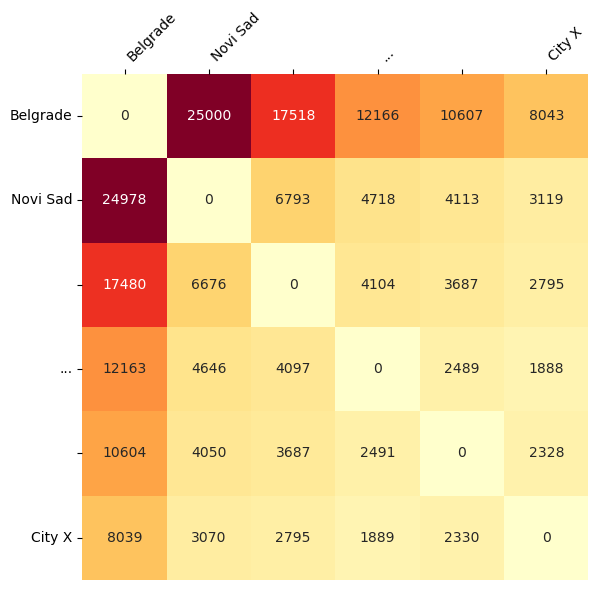

In [13]:
# Create custom location labels - only show A, B, ..., and X
custom_labels = ["Belgrade", "Novi Sad", "", "...", "", "City X"]

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(restructured_matrix, 
            annot=True,  # Show values in cells
            fmt='.0f',   # Format numbers as integers (no scientific notation)
            cmap='YlOrRd',  # Color scheme
            xticklabels=custom_labels,
            yticklabels=custom_labels,
            square=True,  # Make cells square
            cbar=False)  # Remove colorbar

plt.xlabel('')
plt.ylabel('')

# Move x-axis labels to top
plt.gca().xaxis.tick_top()
plt.xticks(rotation=45, ha='left')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [14]:
# Baseline matrices
OD_orig_time = run_shortest_paths(graph, grouped_OD, weighting='fft', tqdm_disable=True)
OD_orig_dist = run_shortest_paths(graph, grouped_OD, weighting='road_length', tqdm_disable=True)
np.fill_diagonal(OD_orig_time, np.nan)
np.fill_diagonal(OD_orig_dist, np.nan)

# Speed ratio per OD pair (km/hr)
speed_ratio = np.array(OD_orig_dist) / np.array(OD_orig_time)

# Sister edge lookup
edge_lookup = {(e.source, e.target): e.index for e in graph.es}
edge_pairs = {}
for edge in graph.es:
    sister_key = (edge.target, edge.source)
    edge_pairs[edge.index] = edge_lookup.get(sister_key)

# Setup
tot_edge_length = np.sum(graph.es['road_length'])
tot_edge_time = np.sum(graph.es['fft'])
exp_edge_no = graph.ecount()
result_df = []
processed = set()

for edge in tqdm(range(exp_edge_no), total=exp_edge_no, desc='percolation'):
    if edge in processed:
        continue
    
    exp_g = graph.copy()
    
    # Get edge length (sum of both directions if sister exists)
    edge_length = graph.es[edge]['road_length']
    sister = edge_pairs.get(edge)
    if sister is not None:
        edge_length += graph.es[sister]['road_length']
        processed.add(sister)
    
    # Remove edge and sister
    edges_to_remove = [edge]
    if sister is not None:
        edges_to_remove.append(sister)
    
    exp_g.delete_edges(edges_to_remove)
    
    cur_dis_length = 1 - (np.sum(exp_g.es['road_length']) / tot_edge_length)
    cur_dis_time = 1 - (np.sum(exp_g.es['fft']) / tot_edge_time)
    
    # Only compute TIME matrix in loop
    perc_matrix_time = run_shortest_paths(exp_g, grouped_OD, weighting='fft', tqdm_disable=True)
    np.fill_diagonal(perc_matrix_time, np.nan)
    perc_matrix_time[perc_matrix_time == np.inf] = 6
    
    results = SummariseOD(
        perc_matrix_time, 6, demand, 
        OD_orig_time, speed_ratio, edge_length,
        graph.es[edge]['id'], cur_dis_length, cur_dis_time
    )
    result_df.append(results)

result_df = pd.DataFrame(result_df, columns=[
    'edge_no', 'pct_isolated', 'pct_unaffected', 'pct_delayed',
    'average_time_disruption', 'average_dist_disruption',
    'distance_disruption', 'time_disruption'
])

percolation: 100%|██████████| 5490/5490 [21:10<00:00,  4.32it/s] 


In [15]:
gdf_results = edges.merge(result_df,left_index=True,right_on='edge_no')

In [16]:
gdf_results.columns

Index(['from_id', 'to_id', 'objectid', 'oznaka_deo', 'smer_gdf1', 'kategorija',
       'oznaka_put', 'oznaka_poc', 'naziv_poce', 'oznaka_zav', 'naziv_zavr',
       'duzina_deo', 'pocetna_st', 'zavrsna_st', 'stanje', 'geometry', 'id',
       'passenger_cars', 'buses', 'light_trucks', 'medium_trucks',
       'heavy_trucks', 'articulated_vehicles', 'total_aadt', 'oznaka_deo_left',
       'index_right', 'oznaka_deo_right', 'road_length', 'speed', 'fft',
       'edge_no', 'pct_isolated', 'pct_unaffected', 'pct_delayed',
       'average_time_disruption', 'average_dist_disruption',
       'distance_disruption', 'time_disruption'],
      dtype='object')

In [17]:
vhl_df = pd.DataFrame(result_df[['edge_no','average_time_disruption']],columns=['edge_no','average_time_disruption'])
gdf_vhl = edges.merge(vhl_df,left_index=True,right_on='edge_no')
gdf_vhl['vhl'] = gdf_vhl.average_time_disruption*gdf_vhl.total_aadt

In [18]:
gdf_results['vhl'] = gdf_results.average_time_disruption*gdf_results.total_aadt
gdf_results['vkl'] = gdf_results['average_dist_disruption'] * gdf_results['total_aadt']

In [19]:
gdf_results.loc[gdf_results.pct_isolated > 0]

,from_id,to_id,objectid,oznaka_deo,smer_gdf1,kategorija,oznaka_put,oznaka_poc,naziv_poce,oznaka_zav,...,edge_no,pct_isolated,pct_unaffected,pct_delayed,average_time_disruption,average_dist_disruption,distance_disruption,time_disruption,vhl,vkl
47,67,45,32.0,A1028,L,IA,A1,A114,petlja Novi Sad jug,A113,...,53,0.094967,98.686534,1.313466,0.411389,4.487239,2.022421e-04,2.022421e-04,4911.985583,53577.628882
50,69,70,34.0,A1015,D,IA,A1,A107,petlja Mali I?oš,A108,...,56,0.094967,98.715511,1.284489,0.293173,4.733645,2.020101e-04,2.020101e-04,4290.579584,69276.891101
54,74,75,38.0,A1034,L,IA,A1,A117,petlja Maradik,A116,...,60,0.094967,98.686534,1.313466,0.428596,4.910881,3.261112e-04,3.261112e-04,13479.782507,154452.124463
57,72,78,41.0,A1035,D,IA,A1,A117,petlja Maradik,A118,...,63,0.094967,93.179996,6.820004,0.333736,24.441672,1.426546e-04,1.426546e-04,10795.698498,790639.190972
58,79,80,41.0,A1035,D,IA,A1,A117,petlja Maradik,A118,...,65,0.094967,98.715511,1.284489,0.303644,5.065192,3.439353e-04,3.439353e-04,9822.281817,163848.817511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2930,2266,2267,526.0,,,,A2,dA20703,,dA20705,...,3020,0.094967,96.985889,3.014111,0.689349,24.574291,1.888697e-05,1.888697e-05,8552.068140,304868.650182
2960,417,2277,538.0,,,,A2,dA20606,,dA20607,...,3050,0.094967,99.809705,0.190295,1.175996,0.904312,1.681496e-05,1.681496e-05,14589.403388,11218.890216
3014,1900,2239,596.0,,,,A1,dA12810,,dA12811,...,3104,0.189934,99.810066,0.189934,2.983256,0.060568,2.002876e-06,2.002876e-06,37010.272718,751.408505
3051,1799,2316,1020.0,,,,A3,dA30807,,dA30808,...,3141,0.189934,99.810066,0.189934,4.144030,0.008707,2.879322e-07,2.879322e-07,51410.842112,108.021999


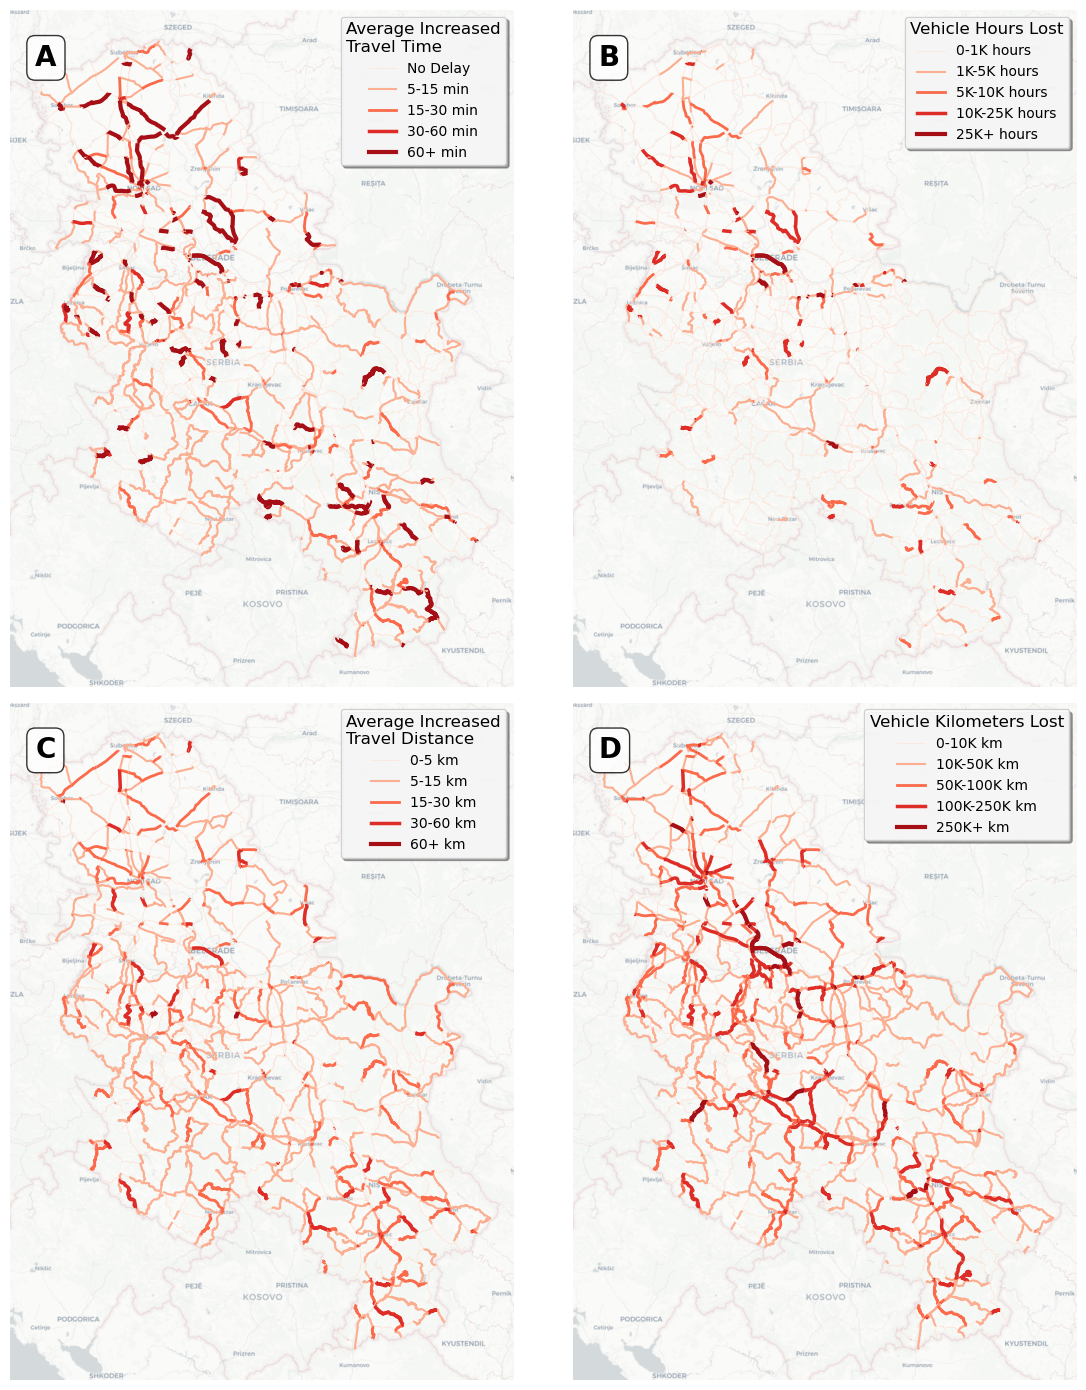

In [20]:
# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 14), facecolor='white')
colors = ['#fee5d9', '#fcae91', '#fb6a4a', '#de2d26', '#a50f15']

# ============ TOP LEFT (A) - Average Time Delay ============
ax1 = axes[0, 0]
bins1 = [0, 0.08335, 0.25, 0.5, 1, np.inf]
labels1 = ['No Delay', '5-15 min', '15-30 min', '30-60 min', '60+ min']
gdf_results['disruption_class'] = pd.cut(
    gdf_results['average_time_disruption'], 
    bins=bins1, labels=labels1, include_lowest=True
)
linewidth_map1 = {
    'No Delay': 0.5, '5-15 min': 1.5, '15-30 min': 2.0, 
    '30-60 min': 2.5, '60+ min': 3.0
}
for i, (class_name, width) in enumerate(linewidth_map1.items()):
    subset = gdf_results[gdf_results['disruption_class'] == class_name]
    if not subset.empty:
        subset.to_crs(3857).plot(ax=ax1, color=colors[i], linewidth=width, alpha=1)
cx.add_basemap(ax=ax1, source=cx.providers.CartoDB.Positron, attribution=False)
ax1.set_aspect('equal')
ax1.axis('off')
legend_elements1 = [Line2D([0], [0], color=colors[i], lw=width, label=class_name)
                    for i, (class_name, width) in enumerate(linewidth_map1.items())]
ax1.legend(handles=legend_elements1, title='Average Increased\nTravel Time', loc='upper right',
           fontsize=10, title_fontsize=12, frameon=True, fancybox=True, shadow=True,
           framealpha=0.9, facecolor='white', edgecolor='#cccccc')
ax1.text(0.05, 0.95, 'A', transform=ax1.transAxes, fontsize=20, fontweight='bold',
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# ============ TOP RIGHT (B) - Vehicle Hours Lost ============
ax2 = axes[0, 1]
bins2 = [0, 1000, 5000, 10000, 25000, np.inf]
labels2 = ['0-1K', '1K-5K', '5K-10K', '10K-25K', '25K+']
gdf_results['vhl_class'] = pd.cut(
    gdf_results['vhl'], 
    bins=bins2, labels=labels2, include_lowest=True
)
linewidth_map2 = {
    '0-1K': 0.5, '1K-5K': 1.5, '5K-10K': 2.0, 
    '10K-25K': 2.5, '25K+': 3.0
}
for i, (class_name, width) in enumerate(linewidth_map2.items()):
    subset = gdf_results[gdf_results['vhl_class'] == class_name]
    if not subset.empty:
        subset.to_crs(3857).plot(ax=ax2, color=colors[i], linewidth=width, alpha=1)
cx.add_basemap(ax=ax2, source=cx.providers.CartoDB.Positron, attribution=False)
ax2.set_aspect('equal')
ax2.axis('off')
legend_elements2 = [Line2D([0], [0], color=colors[i], lw=width, label=f'{class_name} hours')
                    for i, (class_name, width) in enumerate(linewidth_map2.items())]
ax2.legend(handles=legend_elements2, title='Vehicle Hours Lost', loc='upper right',
           fontsize=10, title_fontsize=12, frameon=True, fancybox=True, shadow=True,
           framealpha=0.9, facecolor='white', edgecolor='#cccccc')
ax2.text(0.05, 0.95, 'B', transform=ax2.transAxes, fontsize=20, fontweight='bold',
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# ============ BOTTOM LEFT (C) - Average Distance Disruption ============
ax3 = axes[1, 0]
bins3 = [0, 5, 15, 30, 60, np.inf]
labels3 = ['0-5 km', '5-15 km', '15-30 km', '30-60 km', '60+ km']
gdf_results['dist_class'] = pd.cut(
    gdf_results['average_dist_disruption'], 
    bins=bins3, labels=labels3, include_lowest=True
)
linewidth_map3 = {
    '0-5 km': 0.5, '5-15 km': 1.5, '15-30 km': 2.0, 
    '30-60 km': 2.5, '60+ km': 3.0
}
for i, (class_name, width) in enumerate(linewidth_map3.items()):
    subset = gdf_results[gdf_results['dist_class'] == class_name]
    if not subset.empty:
        subset.to_crs(3857).plot(ax=ax3, color=colors[i], linewidth=width, alpha=1)
cx.add_basemap(ax=ax3, source=cx.providers.CartoDB.Positron, attribution=False)
ax3.set_aspect('equal')
ax3.axis('off')
legend_elements3 = [Line2D([0], [0], color=colors[i], lw=width, label=class_name)
                    for i, (class_name, width) in enumerate(linewidth_map3.items())]
ax3.legend(handles=legend_elements3, title='Average Increased\nTravel Distance', loc='upper right',
           fontsize=10, title_fontsize=12, frameon=True, fancybox=True, shadow=True,
           framealpha=0.9, facecolor='white', edgecolor='#cccccc')
ax3.text(0.05, 0.95, 'C', transform=ax3.transAxes, fontsize=20, fontweight='bold',
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# ============ BOTTOM RIGHT (D) - Vehicle Kilometers Lost ============
ax4 = axes[1, 1]
bins4 = [0, 10000, 50000, 100000, 250000, np.inf]
labels4 = ['0-10K', '10K-50K', '50K-100K', '100K-250K', '250K+']
gdf_results['vkl_class'] = pd.cut(
    gdf_results['vkl'], 
    bins=bins4, labels=labels4, include_lowest=True
)
linewidth_map4 = {
    '0-10K': 0.5, '10K-50K': 1.5, '50K-100K': 2.0, 
    '100K-250K': 2.5, '250K+': 3.0
}
for i, (class_name, width) in enumerate(linewidth_map4.items()):
    subset = gdf_results[gdf_results['vkl_class'] == class_name]
    if not subset.empty:
        subset.to_crs(3857).plot(ax=ax4, color=colors[i], linewidth=width, alpha=1)
cx.add_basemap(ax=ax4, source=cx.providers.CartoDB.Positron, attribution=False)
ax4.set_aspect('equal')
ax4.axis('off')
legend_elements4 = [Line2D([0], [0], color=colors[i], lw=width, label=f'{class_name} km')
                    for i, (class_name, width) in enumerate(linewidth_map4.items())]
ax4.legend(handles=legend_elements4, title='Vehicle Kilometers Lost', loc='upper right',
           fontsize=10, title_fontsize=12, frameon=True, fancybox=True, shadow=True,
           framealpha=0.9, facecolor='white', edgecolor='#cccccc')
ax4.text(0.05, 0.95, 'D', transform=ax4.transAxes, fontsize=20, fontweight='bold',
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# Final adjustments
plt.tight_layout()
plt.savefig(figure_path / 'SPOF_results_2x2.png', dpi=300, bbox_inches='tight')
plt.show()

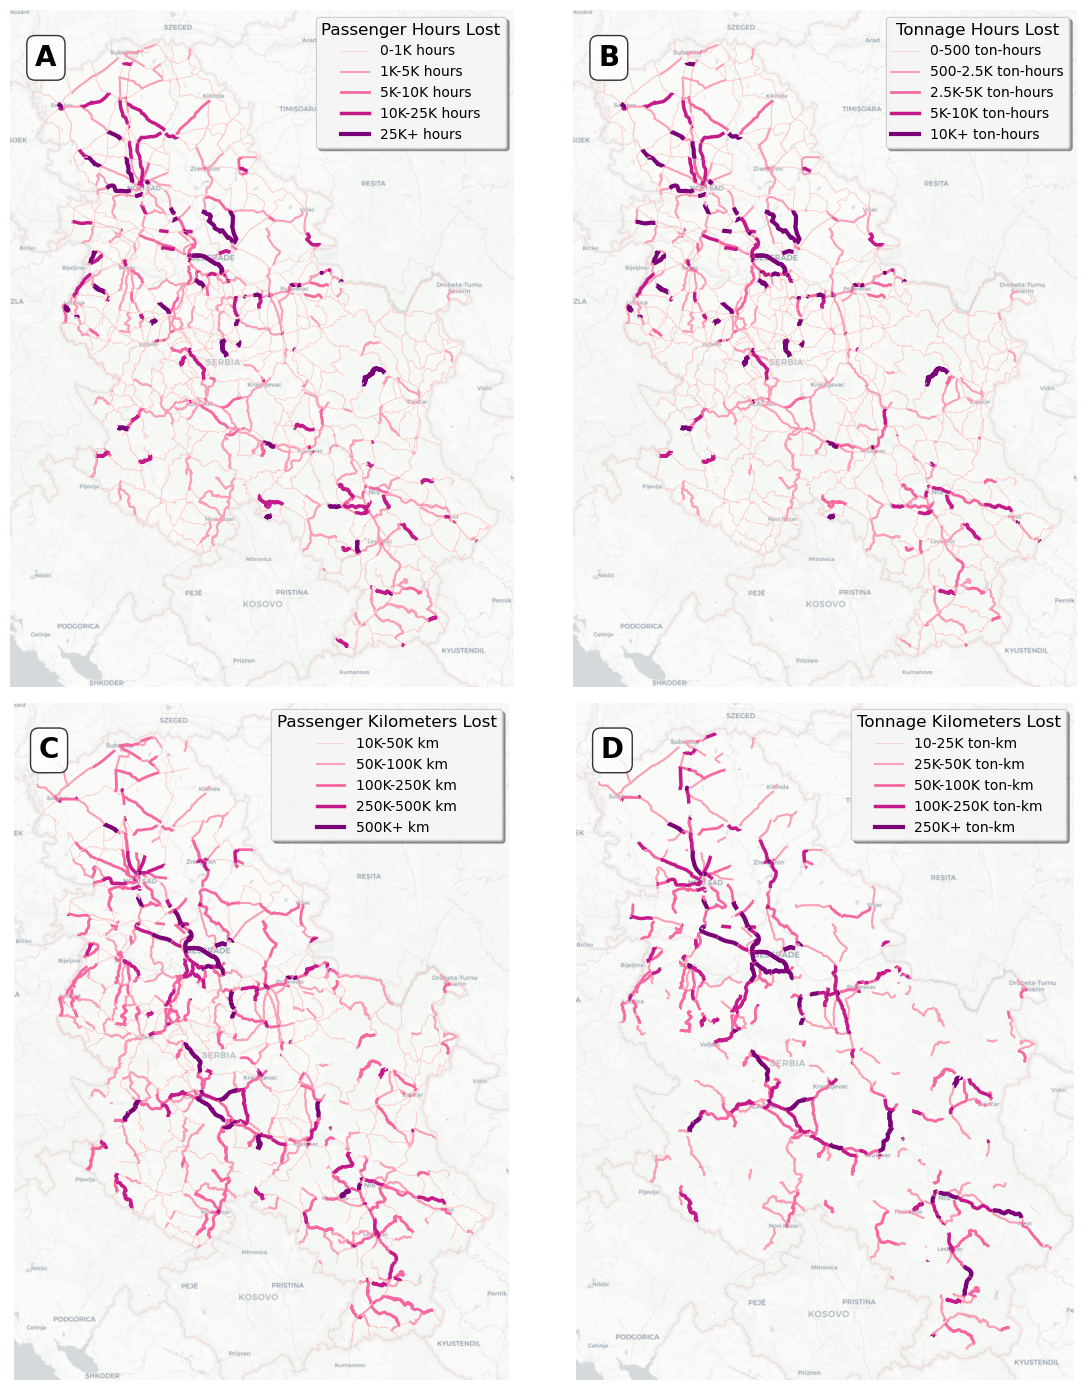

In [21]:
# Compute PHL, THL, PKL, TKL
gdf_results['phl'] = gdf_results['average_time_disruption'] * (
    gdf_results['passenger_cars'] * 2 + 
    gdf_results['buses'] * 30
)
gdf_results['thl'] = gdf_results['average_time_disruption'] * (
    gdf_results['light_trucks'] * 1.2 + 
    gdf_results['medium_trucks'] * 3.8 + 
    gdf_results['heavy_trucks'] * 8.0 + 
    gdf_results['articulated_vehicles'] * 14.5
)
gdf_results['pkl'] = gdf_results['average_dist_disruption'] * (
    gdf_results['passenger_cars'] * 2 + 
    gdf_results['buses'] * 30
)
gdf_results['tkl'] = gdf_results['average_dist_disruption'] * (
    gdf_results['light_trucks'] * 1.2 + 
    gdf_results['medium_trucks'] * 3.8 + 
    gdf_results['heavy_trucks'] * 8.0 + 
    gdf_results['articulated_vehicles'] * 14.5
)

# Create 2x2 figure
fig, axes = plt.subplots(2, 2, figsize=(12, 14), facecolor='white')
colors = ['#fcc5c0','#fa9fb5','#f768a1','#c51b8a','#7a0177']

# ============ TOP LEFT (A) - Passenger Hours Lost ============
ax1 = axes[0, 0]
bins1 = [0, 1000, 5000, 10000, 25000, np.inf]
labels1 = ['0-1K', '1K-5K', '5K-10K', '10K-25K', '25K+']
gdf_results['phl_class'] = pd.cut(
    gdf_results['phl'], 
    bins=bins1, labels=labels1, include_lowest=True
)
linewidth_map1 = {
    '0-1K': 0.5, '1K-5K': 1.5, '5K-10K': 2.0, 
    '10K-25K': 2.5, '25K+': 3.0
}
for i, (class_name, width) in enumerate(linewidth_map1.items()):
    subset = gdf_results[gdf_results['phl_class'] == class_name]
    if not subset.empty:
        subset.to_crs(3857).plot(ax=ax1, color=colors[i], linewidth=width, alpha=1)
cx.add_basemap(ax=ax1, source=cx.providers.CartoDB.Positron, attribution=False)
ax1.set_aspect('equal')
ax1.axis('off')
legend_elements1 = [Line2D([0], [0], color=colors[i], lw=width, label=f'{class_name} hours')
                    for i, (class_name, width) in enumerate(linewidth_map1.items())]
ax1.legend(handles=legend_elements1, title='Passenger Hours Lost', loc='upper right',
           fontsize=10, title_fontsize=12, frameon=True, fancybox=True, shadow=True,
           framealpha=0.9, facecolor='white', edgecolor='#cccccc')
ax1.text(0.05, 0.95, 'A', transform=ax1.transAxes, fontsize=20, fontweight='bold',
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# ============ TOP RIGHT (B) - Tonnage Hours Lost ============
ax2 = axes[0, 1]
bins2 = [0, 500, 2500, 5000, 10000, np.inf]
labels2 = ['0-500', '500-2.5K', '2.5K-5K', '5K-10K', '10K+']
gdf_results['thl_class'] = pd.cut(
    gdf_results['thl'], 
    bins=bins2, labels=labels2, include_lowest=True
)
linewidth_map2 = {
    '0-500': 0.5, '500-2.5K': 1.5, '2.5K-5K': 2.0, 
    '5K-10K': 2.5, '10K+': 3.0
}
for i, (class_name, width) in enumerate(linewidth_map2.items()):
    subset = gdf_results[gdf_results['thl_class'] == class_name]
    if not subset.empty:
        subset.to_crs(3857).plot(ax=ax2, color=colors[i], linewidth=width, alpha=1)
cx.add_basemap(ax=ax2, source=cx.providers.CartoDB.Positron, attribution=False)
ax2.set_aspect('equal')
ax2.axis('off')
legend_elements2 = [Line2D([0], [0], color=colors[i], lw=width, label=f'{class_name} ton-hours')
                    for i, (class_name, width) in enumerate(linewidth_map2.items())]
ax2.legend(handles=legend_elements2, title='Tonnage Hours Lost', loc='upper right',
           fontsize=10, title_fontsize=12, frameon=True, fancybox=True, shadow=True,
           framealpha=0.9, facecolor='white', edgecolor='#cccccc')
ax2.text(0.05, 0.95, 'B', transform=ax2.transAxes, fontsize=20, fontweight='bold',
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# ============ BOTTOM LEFT (C) - Passenger Kilometers Lost ============
ax3 = axes[1, 0]
bins3 = [10000, 50000, 100000, 250000, 500000, np.inf]
labels3 = ['10K-50K', '50K-100K', '100K-250K', '250K-500K', '500K+']
gdf_results['pkl_class'] = pd.cut(
    gdf_results['pkl'], 
    bins=bins3, labels=labels3, include_lowest=True
)
linewidth_map3 = {
    '10K-50K': 0.5, '50K-100K': 1.5, '100K-250K': 2.0, 
    '250K-500K': 2.5, '500K+': 3.0
}
for i, (class_name, width) in enumerate(linewidth_map3.items()):
    subset = gdf_results[gdf_results['pkl_class'] == class_name]
    if not subset.empty:
        subset.to_crs(3857).plot(ax=ax3, color=colors[i], linewidth=width, alpha=1)
cx.add_basemap(ax=ax3, source=cx.providers.CartoDB.Positron, attribution=False)
ax3.set_aspect('equal')
ax3.axis('off')
legend_elements3 = [Line2D([0], [0], color=colors[i], lw=width, label=f'{class_name} km')
                    for i, (class_name, width) in enumerate(linewidth_map3.items())]
ax3.legend(handles=legend_elements3, title='Passenger Kilometers Lost', loc='upper right',
           fontsize=10, title_fontsize=12, frameon=True, fancybox=True, shadow=True,
           framealpha=0.9, facecolor='white', edgecolor='#cccccc')
ax3.text(0.05, 0.95, 'C', transform=ax3.transAxes, fontsize=20, fontweight='bold',
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# ============ BOTTOM RIGHT (D) - Tonnage Kilometers Lost ============
ax4 = axes[1, 1]
bins4 = [10000, 25000, 50000, 100000, 250000, np.inf]
labels4 = ['5K-25K', '25K-50K', '50K-100K', '100K-250K', '250K+']
gdf_results['tkl_class'] = pd.cut(
    gdf_results['tkl'], 
    bins=bins4, labels=labels4, include_lowest=True
)
linewidth_map4 = {
    '10-25K': 0.5, '25K-50K': 1.5, '50K-100K': 2.0, 
    '100K-250K': 2.5, '250K+': 3.0
}
for i, (class_name, width) in enumerate(linewidth_map4.items()):
    subset = gdf_results[gdf_results['tkl_class'] == class_name]
    if not subset.empty:
        subset.to_crs(3857).plot(ax=ax4, color=colors[i], linewidth=width, alpha=1)
cx.add_basemap(ax=ax4, source=cx.providers.CartoDB.Positron, attribution=False)
ax4.set_aspect('equal')
ax4.axis('off')
legend_elements4 = [Line2D([0], [0], color=colors[i], lw=width, label=f'{class_name} ton-km')
                    for i, (class_name, width) in enumerate(linewidth_map4.items())]
ax4.legend(handles=legend_elements4, title='Tonnage Kilometers Lost', loc='upper right',
           fontsize=10, title_fontsize=12, frameon=True, fancybox=True, shadow=True,
           framealpha=0.9, facecolor='white', edgecolor='#cccccc')
ax4.text(0.05, 0.95, 'D', transform=ax4.transAxes, fontsize=20, fontweight='bold',
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# Final adjustments
plt.tight_layout()
plt.savefig(figure_path / 'SPOF_PHL_THL_PKL_TKL.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
gdf_results[['from_id', 'to_id', 'objectid', 'oznaka_deo', 'smer_gdf1', 'kategorija',
       'oznaka_put', 'oznaka_poc', 'naziv_poce', 'oznaka_zav', 'naziv_zavr',
       'duzina_deo', 'pocetna_st', 'zavrsna_st', 'stanje', 'id',
       'passenger_cars', 'buses', 'light_trucks', 'medium_trucks',
       'heavy_trucks', 'articulated_vehicles', 'total_aadt', 'oznaka_deo_left',
       'index_right', 'oznaka_deo_right', 'road_length', 'speed', 'fft',
       'geometry', 'edge_no', 'pct_isolated', 'pct_unaffected', 'pct_delayed',
       'average_time_disruption', 'average_dist_disruption' ,'distance_disruption', 'time_disruption','vhl','phl','thl','pkl','tkl']].to_parquet(intermediate_path / "criticality_results.parquet")


SUMMARY STATISTICS

Descriptive Statistics:
       average_time_disruption  average_dist_disruption            phl  \
count             2.859000e+03             2.859000e+03    2859.000000   
mean              2.241409e-01             6.560057e+00    3195.205798   
std               6.301431e-01             8.280332e+00   10883.559981   
min               1.294853e-10             1.035882e-08       0.000004   
25%               7.881032e-03             5.379714e-01     114.039138   
50%               5.615434e-02             4.105217e+00     524.948704   
75%               1.321495e-01             9.085901e+00    1651.472763   
max               4.205148e+00             8.248131e+01  143997.762981   

                 thl           pkl           tkl  
count    2859.000000  2.859000e+03  2.859000e+03  
mean     1828.018627  9.783955e+04  5.763886e+04  
std      7173.327613  1.850611e+05  1.412130e+05  
min         0.000002  2.885346e-04  1.351111e-04  
25%        55.423924  8.471686e+03

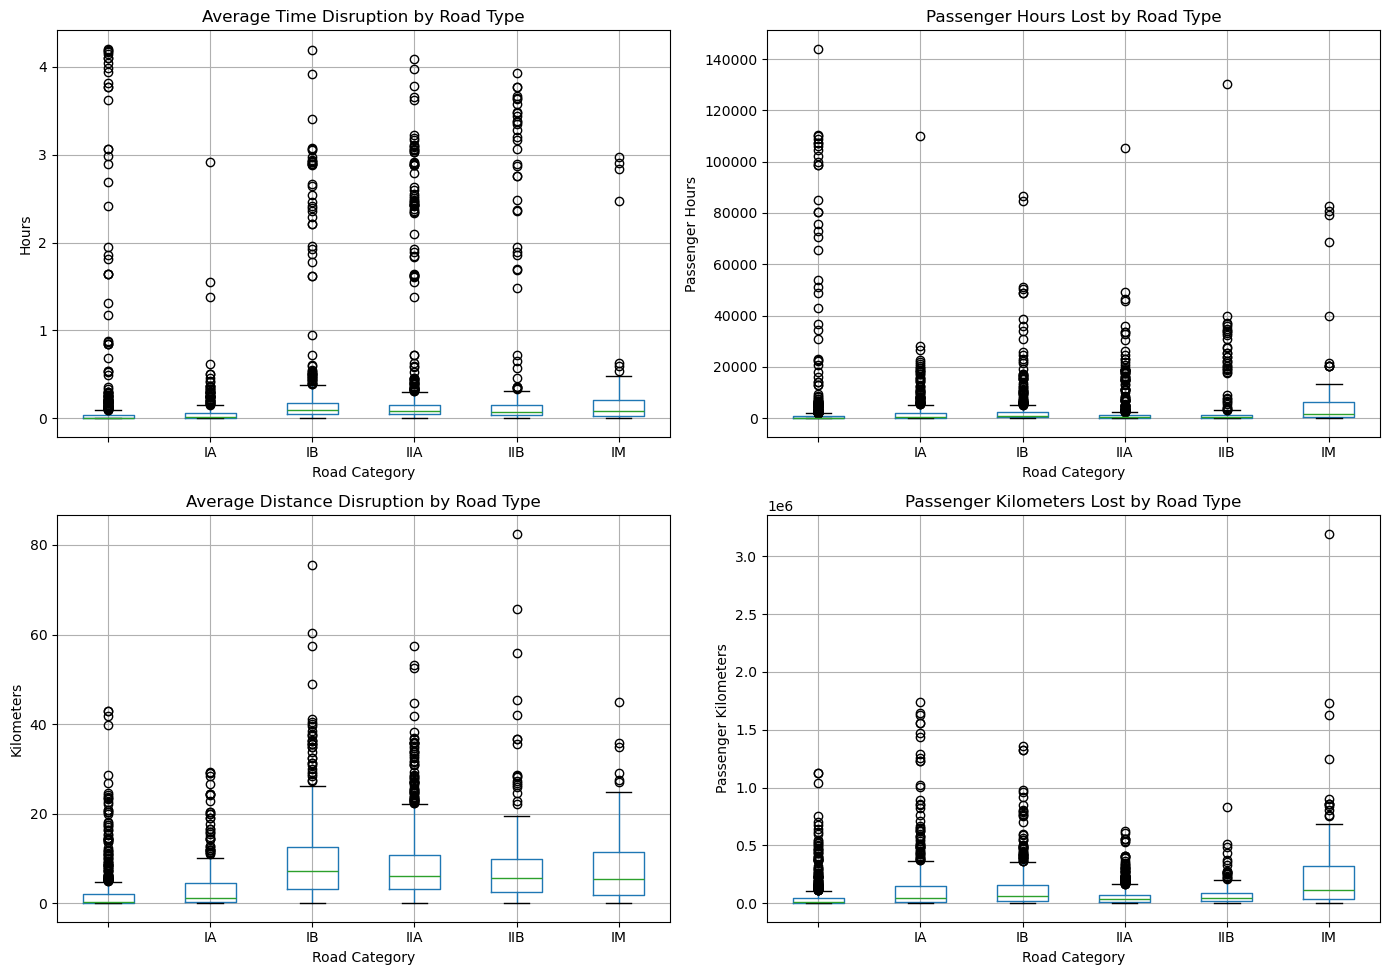

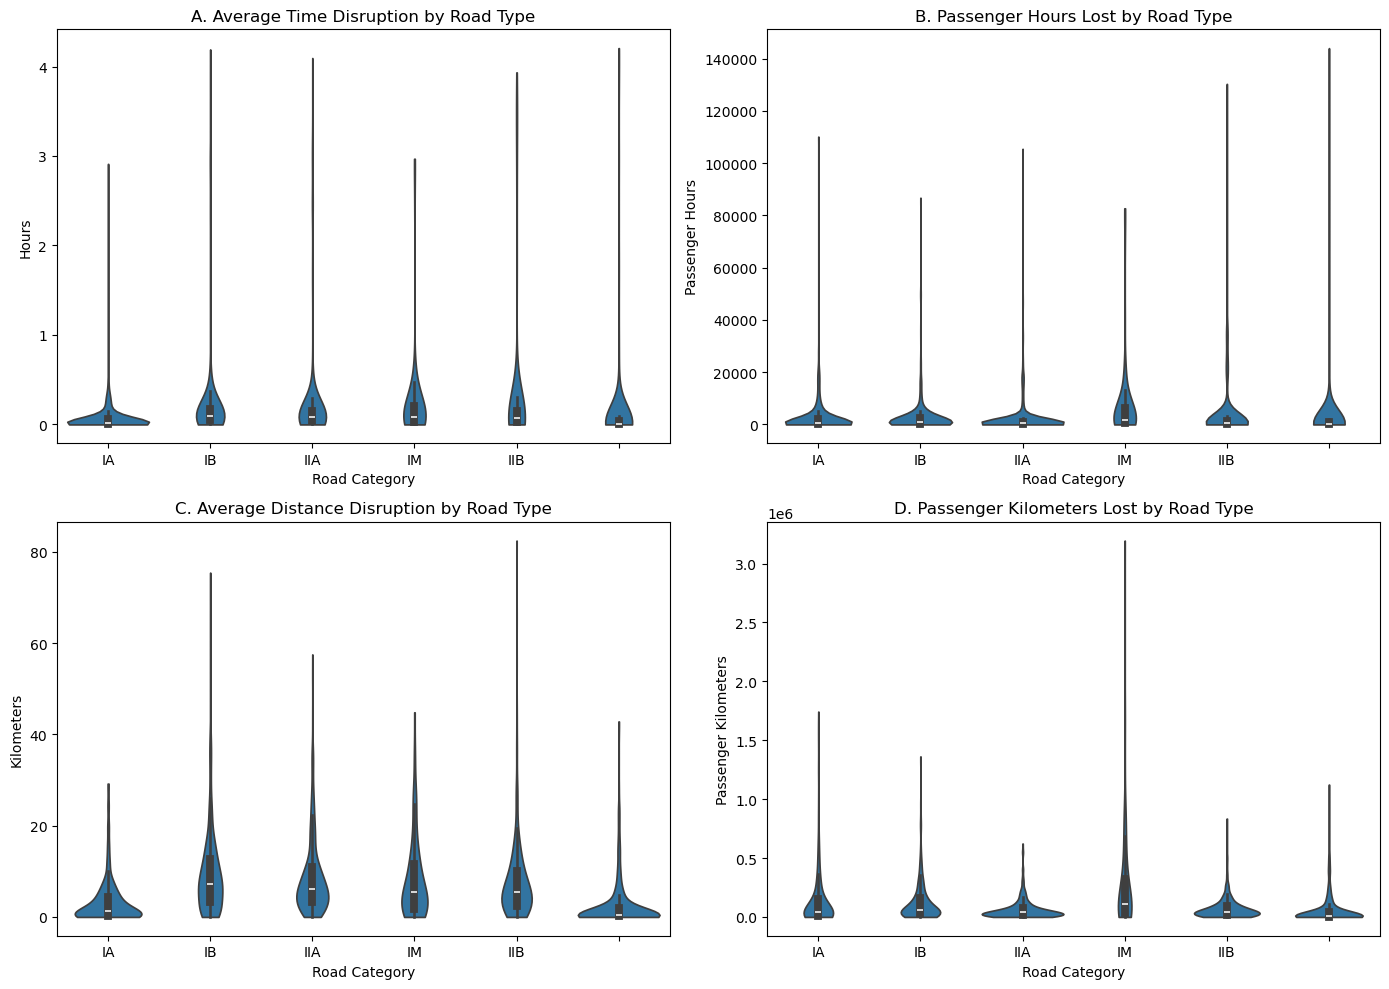


AADT VS CRITICALITY ANALYSIS


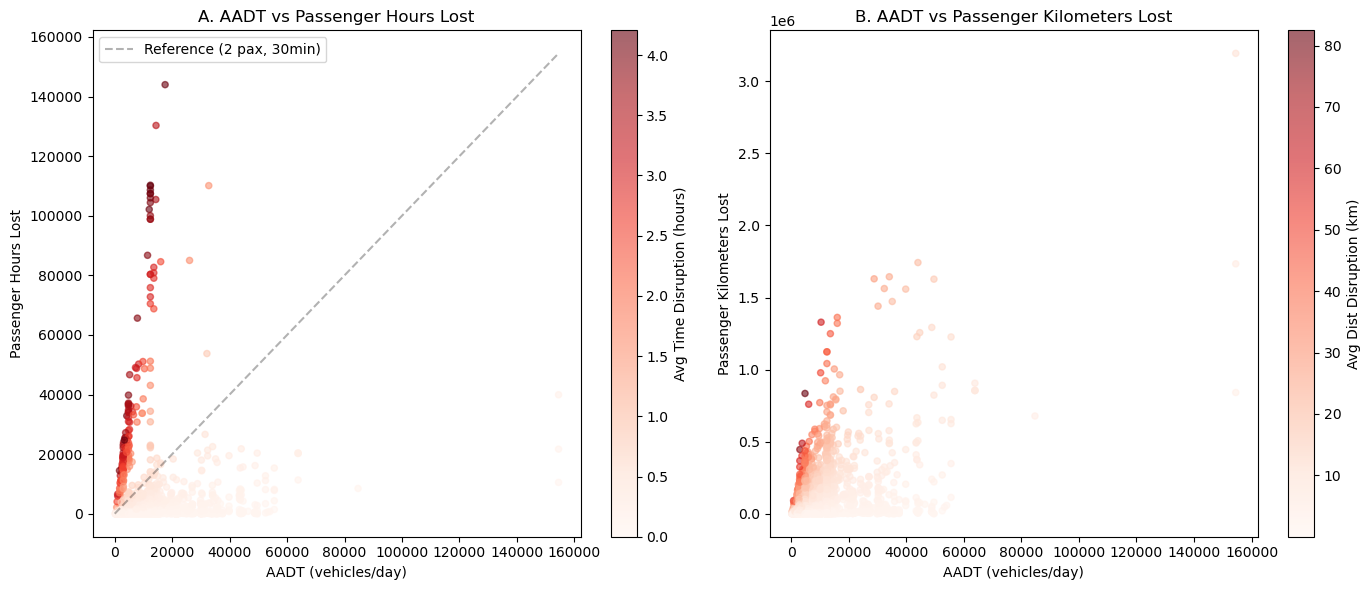


Linear Regression (AADT vs PHL):
  R-squared: 0.013
  Slope: 0.1170
  Intercept: 1795.47

----------------------------------------
HIGH AADT BUT LOW CRITICALITY (underperforming expectations):
----------------------------------------
      edge_no kategorija  total_aadt  average_time_disruption           phl  phl_expected  phl_residual
1350     1396         IM   154504.00                 0.028939  10511.559459  19871.458423  -9359.898964
78         86         IA    52486.00                 0.002437    253.094716   7935.999592  -7682.904876
147       157         IA    49597.00                 0.000035      3.427077   7598.004919  -7594.577842
149       159         IA    49597.00                 0.000038      3.713341   7598.004919  -7594.291578
2308     2398               53250.75                 0.005406    569.975590   8025.470491  -7455.494901
2311     2401               54015.50                 0.006742    721.284851   8114.941390  -7393.656539
345       358         IA    48855.00 

In [23]:
# ============================================================
# PART 1: Summary Statistics for New Metrics
# ============================================================

print("="*60)
print("SUMMARY STATISTICS")
print("="*60)

# Basic stats
metrics = ['average_time_disruption', 'average_dist_disruption', 'phl', 'thl', 'pkl', 'tkl']
print("\nDescriptive Statistics:")
print(gdf_results[metrics].describe())

# Percentage breakdown for each metric
print("\n" + "="*60)
print("PERCENTAGE BREAKDOWNS")
print("="*60)

# Time disruption categories
total_sections = len(gdf_results)
no_delay = (gdf_results['average_time_disruption'] == 0).sum()
delay_5_15 = ((gdf_results['average_time_disruption'] > 0) & (gdf_results['average_time_disruption'] <= 0.25)).sum()
delay_15_30 = ((gdf_results['average_time_disruption'] > 0.25) & (gdf_results['average_time_disruption'] <= 0.5)).sum()
delay_30_60 = ((gdf_results['average_time_disruption'] > 0.5) & (gdf_results['average_time_disruption'] <= 1)).sum()
delay_60_plus = (gdf_results['average_time_disruption'] > 1).sum()

print(f"\nTime Disruption (n={total_sections}):")
print(f"  No delay: {no_delay} ({no_delay/total_sections*100:.1f}%)")
print(f"  5-15 min: {delay_5_15} ({delay_5_15/total_sections*100:.1f}%)")
print(f"  15-30 min: {delay_15_30} ({delay_15_30/total_sections*100:.1f}%)")
print(f"  30-60 min: {delay_30_60} ({delay_30_60/total_sections*100:.1f}%)")
print(f"  60+ min: {delay_60_plus} ({delay_60_plus/total_sections*100:.1f}%)")

# PHL categories
phl_0_1k = (gdf_results['phl'] <= 1000).sum()
phl_1k_5k = ((gdf_results['phl'] > 1000) & (gdf_results['phl'] <= 5000)).sum()
phl_5k_10k = ((gdf_results['phl'] > 5000) & (gdf_results['phl'] <= 10000)).sum()
phl_10k_25k = ((gdf_results['phl'] > 10000) & (gdf_results['phl'] <= 25000)).sum()
phl_25k_plus = (gdf_results['phl'] > 25000).sum()

print(f"\nPassenger Hours Lost (n={total_sections}):")
print(f"  0-1K: {phl_0_1k} ({phl_0_1k/total_sections*100:.1f}%)")
print(f"  1K-5K: {phl_1k_5k} ({phl_1k_5k/total_sections*100:.1f}%)")
print(f"  5K-10K: {phl_5k_10k} ({phl_5k_10k/total_sections*100:.1f}%)")
print(f"  10K-25K: {phl_10k_25k} ({phl_10k_25k/total_sections*100:.1f}%)")
print(f"  25K+: {phl_25k_plus} ({phl_25k_plus/total_sections*100:.1f}%)")

# PKL categories (>10K only)
pkl_10k_50k = ((gdf_results['pkl'] > 10000) & (gdf_results['pkl'] <= 50000)).sum()
pkl_50k_100k = ((gdf_results['pkl'] > 50000) & (gdf_results['pkl'] <= 100000)).sum()
pkl_100k_250k = ((gdf_results['pkl'] > 100000) & (gdf_results['pkl'] <= 250000)).sum()
pkl_250k_500k = ((gdf_results['pkl'] > 250000) & (gdf_results['pkl'] <= 500000)).sum()
pkl_500k_plus = (gdf_results['pkl'] > 500000).sum()

print(f"\nPassenger Kilometers Lost (>10K only):")
print(f"  10K-50K: {pkl_10k_50k} ({pkl_10k_50k/total_sections*100:.1f}%)")
print(f"  50K-100K: {pkl_50k_100k} ({pkl_50k_100k/total_sections*100:.1f}%)")
print(f"  100K-250K: {pkl_100k_250k} ({pkl_100k_250k/total_sections*100:.1f}%)")
print(f"  250K-500K: {pkl_250k_500k} ({pkl_250k_500k/total_sections*100:.1f}%)")
print(f"  500K+: {pkl_500k_plus} ({pkl_500k_plus/total_sections*100:.1f}%)")

# Top 10 most critical sections
print("\n" + "="*60)
print("TOP 10 MOST CRITICAL SECTIONS")
print("="*60)
top_phl = gdf_results.nlargest(10, 'phl')[['edge_no', 'kategorija', 'average_time_disruption', 
                                            'average_dist_disruption', 'total_aadt', 'phl', 'pkl']]
print("\nBy Passenger Hours Lost:")
print(top_phl.to_string())

top_pkl = gdf_results.nlargest(10, 'pkl')[['edge_no', 'kategorija', 'average_time_disruption', 
                                            'average_dist_disruption', 'total_aadt', 'phl', 'pkl']]
print("\nBy Passenger Kilometers Lost:")
print(top_pkl.to_string())


# ============================================================
# PART 2: Distribution by Road Type (for Appendix)
# ============================================================

print("\n" + "="*60)
print("DISTRIBUTION BY ROAD TYPE")
print("="*60)

# Summary by road category
road_type_summary = gdf_results.groupby('kategorija').agg({
    'edge_no': 'count',
    'average_time_disruption': ['mean', 'median', 'max'],
    'average_dist_disruption': ['mean', 'median', 'max'],
    'phl': ['mean', 'median', 'max', 'sum'],
    'pkl': ['mean', 'median', 'max', 'sum'],
    'thl': ['mean', 'median', 'max', 'sum'],
    'tkl': ['mean', 'median', 'max', 'sum'],
    'total_aadt': ['mean', 'median']
}).round(2)

print("\nSummary by Road Category:")
print(road_type_summary)

# Create visualization for appendix - boxplots by road type
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# A: Time disruption by road type
ax1 = axes[0, 0]
gdf_results.boxplot(column='average_time_disruption', by='kategorija', ax=ax1)
ax1.set_title('Average Time Disruption by Road Type')
ax1.set_xlabel('Road Category')
ax1.set_ylabel('Hours')
plt.suptitle('')

# B: PHL by road type
ax2 = axes[0, 1]
gdf_results.boxplot(column='phl', by='kategorija', ax=ax2)
ax2.set_title('Passenger Hours Lost by Road Type')
ax2.set_xlabel('Road Category')
ax2.set_ylabel('Passenger Hours')
plt.suptitle('')

# C: Distance disruption by road type
ax3 = axes[1, 0]
gdf_results.boxplot(column='average_dist_disruption', by='kategorija', ax=ax3)
ax3.set_title('Average Distance Disruption by Road Type')
ax3.set_xlabel('Road Category')
ax3.set_ylabel('Kilometers')
plt.suptitle('')

# D: PKL by road type
ax4 = axes[1, 1]
gdf_results.boxplot(column='pkl', by='kategorija', ax=ax4)
ax4.set_title('Passenger Kilometers Lost by Road Type')
ax4.set_xlabel('Road Category')
ax4.set_ylabel('Passenger Kilometers')
plt.suptitle('')

plt.tight_layout()
plt.savefig(figure_path / 'SPOF_by_road_type_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

# Alternative: violin plots for better distribution visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

import seaborn as sns

ax1 = axes[0, 0]
sns.violinplot(data=gdf_results, x='kategorija', y='average_time_disruption', ax=ax1, cut=0)
ax1.set_title('A. Average Time Disruption by Road Type')
ax1.set_xlabel('Road Category')
ax1.set_ylabel('Hours')

ax2 = axes[0, 1]
sns.violinplot(data=gdf_results, x='kategorija', y='phl', ax=ax2, cut=0)
ax2.set_title('B. Passenger Hours Lost by Road Type')
ax2.set_xlabel('Road Category')
ax2.set_ylabel('Passenger Hours')

ax3 = axes[1, 0]
sns.violinplot(data=gdf_results, x='kategorija', y='average_dist_disruption', ax=ax3, cut=0)
ax3.set_title('C. Average Distance Disruption by Road Type')
ax3.set_xlabel('Road Category')
ax3.set_ylabel('Kilometers')

ax4 = axes[1, 1]
sns.violinplot(data=gdf_results, x='kategorija', y='pkl', ax=ax4, cut=0)
ax4.set_title('D. Passenger Kilometers Lost by Road Type')
ax4.set_xlabel('Road Category')
ax4.set_ylabel('Passenger Kilometers')

plt.tight_layout()
plt.savefig(figure_path / 'SPOF_by_road_type_violin.png', dpi=300, bbox_inches='tight')
plt.show()


# ============================================================
# PART 3: AADT vs Criticality Scatter Plot
# ============================================================

print("\n" + "="*60)
print("AADT VS CRITICALITY ANALYSIS")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# A: AADT vs PHL
ax1 = axes[0]
scatter1 = ax1.scatter(gdf_results['total_aadt'], gdf_results['phl'], 
                        c=gdf_results['average_time_disruption'], cmap='Reds', 
                        alpha=0.6, s=20)
ax1.set_xlabel('AADT (vehicles/day)')
ax1.set_ylabel('Passenger Hours Lost')
ax1.set_title('A. AADT vs Passenger Hours Lost')
plt.colorbar(scatter1, ax=ax1, label='Avg Time Disruption (hours)')

# Add diagonal reference line (if PHL were purely AADT-driven)
max_aadt = gdf_results['total_aadt'].max()
# Reference: assume 2 passengers, 0.5 hour average delay
ax1.plot([0, max_aadt], [0, max_aadt * 2 * 0.5], 'k--', alpha=0.3, label='Reference (2 pax, 30min)')
ax1.legend()

# B: AADT vs PKL
ax2 = axes[1]
scatter2 = ax2.scatter(gdf_results['total_aadt'], gdf_results['pkl'], 
                        c=gdf_results['average_dist_disruption'], cmap='Reds', 
                        alpha=0.6, s=20)
ax2.set_xlabel('AADT (vehicles/day)')
ax2.set_ylabel('Passenger Kilometers Lost')
ax2.set_title('B. AADT vs Passenger Kilometers Lost')
plt.colorbar(scatter2, ax=ax2, label='Avg Dist Disruption (km)')

plt.tight_layout()
plt.savefig(figure_path / 'SPOF_AADT_vs_criticality.png', dpi=300, bbox_inches='tight')
plt.show()

# Identify outliers: high AADT but low criticality, and vice versa
# Calculate expected PHL based on AADT (simple linear model)
from scipy import stats

# Fit linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(
    gdf_results['total_aadt'].fillna(0), 
    gdf_results['phl'].fillna(0)
)

print(f"\nLinear Regression (AADT vs PHL):")
print(f"  R-squared: {r_value**2:.3f}")
print(f"  Slope: {slope:.4f}")
print(f"  Intercept: {intercept:.2f}")

# Calculate residuals
gdf_results['phl_expected'] = slope * gdf_results['total_aadt'] + intercept
gdf_results['phl_residual'] = gdf_results['phl'] - gdf_results['phl_expected']
gdf_results['phl_residual_pct'] = gdf_results['phl_residual'] / gdf_results['phl_expected'] * 100

# High AADT but low criticality (negative residuals)
print("\n" + "-"*40)
print("HIGH AADT BUT LOW CRITICALITY (underperforming expectations):")
print("-"*40)
low_crit = gdf_results.nsmallest(10, 'phl_residual')[['edge_no', 'kategorija', 'total_aadt', 
                                                       'average_time_disruption', 'phl', 
                                                       'phl_expected', 'phl_residual']]
print(low_crit.to_string())

# Low AADT but high criticality (positive residuals)
print("\n" + "-"*40)
print("LOW AADT BUT HIGH CRITICALITY (exceeding expectations):")
print("-"*40)
high_crit = gdf_results.nlargest(10, 'phl_residual')[['edge_no', 'kategorija', 'total_aadt', 
                                                       'average_time_disruption', 'phl', 
                                                       'phl_expected', 'phl_residual']]
print(high_crit.to_string())

# Big IA roads that are NOT critical
print("\n" + "-"*40)
print("CLASS IA ROADS WITH LOW CRITICALITY:")
print("-"*40)
ia_roads = gdf_results[gdf_results['kategorija'] == 'IA']
ia_low_crit = ia_roads.nsmallest(10, 'phl')[['edge_no', 'total_aadt', 'average_time_disruption', 
                                              'average_dist_disruption', 'phl', 'pkl']]
print(ia_low_crit.to_string())
print(f"\nIA roads with PHL < 1000: {(ia_roads['phl'] < 1000).sum()} out of {len(ia_roads)}")


# ============================================================
# PART 4: Comparison with National Statistics
# ============================================================

print("\n" + "="*60)
print("COMPARISON WITH NATIONAL STATISTICS (H1 2025)")
print("="*60)

# National daily averages from statistical report
national_pkm_daily = 2069 * 1e6 / 180  # million pkm for H1 / ~180 days
national_tkm_daily = 4677 * 1e6 / 180  # million tkm for H1 / ~180 days

print(f"\nNational daily averages (road transport, H1 2025):")
print(f"  Passenger-km/day: {national_pkm_daily:,.0f}")
print(f"  Ton-km/day: {national_tkm_daily:,.0f}")

# Our results - max impacts
max_pkl = gdf_results['pkl'].max()
max_tkl = gdf_results['tkl'].max()
total_pkl_top10 = gdf_results.nlargest(10, 'pkl')['pkl'].sum()
total_tkl_top10 = gdf_results.nlargest(10, 'tkl')['tkl'].sum()

print(f"\nOur SPOF results:")
print(f"  Max PKL (single section): {max_pkl:,.0f} ({max_pkl/national_pkm_daily*100:.2f}% of national daily)")
print(f"  Max TKL (single section): {max_tkl:,.0f} ({max_tkl/national_tkm_daily*100:.2f}% of national daily)")
print(f"  Sum of top 10 PKL: {total_pkl_top10:,.0f} ({total_pkl_top10/national_pkm_daily*100:.2f}% of national daily)")
print(f"  Sum of top 10 TKL: {total_tkl_top10:,.0f} ({total_tkl_top10/national_tkm_daily*100:.2f}% of national daily)")

# Same for hours (need to estimate national passenger-hours)
# Assume average trip length from report: ~87 km (2069M pkm / 23.9M passengers)
avg_trip_length_km = 2069 / 23.905  # million pkm / million passengers
# Assume average speed ~60 km/h for road transport
avg_trip_time_hours = avg_trip_length_km / 60
national_passenger_hours_daily = (23.905 * 1e6 / 180) * avg_trip_time_hours

print(f"\nEstimated national passenger-hours/day: {national_passenger_hours_daily:,.0f}")
print(f"  (based on {avg_trip_length_km:.1f} km avg trip at 60 km/h)")

max_phl = gdf_results['phl'].max()
print(f"  Max PHL: {max_phl:,.0f} ({max_phl/national_passenger_hours_daily*100:.2f}% of estimated national daily)")


# ============================================================
# PART 5: Summary table for text
# ============================================================

print("\n" + "="*60)
print("SUMMARY FOR TEXT")
print("="*60)

print(f"""
KEY FIGURES FOR UPDATED TEXT:
- Total sections analyzed: {total_sections}
- Sections with some disruption: {total_sections - no_delay} ({(total_sections - no_delay)/total_sections*100:.1f}%)
- Sections with >15 min delay: {delay_15_30 + delay_30_60 + delay_60_plus} ({(delay_15_30 + delay_30_60 + delay_60_plus)/total_sections*100:.1f}%)
- Sections with >60 min delay: {delay_60_plus} ({delay_60_plus/total_sections*100:.1f}%)

Passenger Hours Lost:
- Max PHL: {gdf_results['phl'].max():,.0f}
- Sections with PHL > 25K: {phl_25k_plus} ({phl_25k_plus/total_sections*100:.1f}%)
- Sections with PHL > 10K: {phl_10k_25k + phl_25k_plus} ({(phl_10k_25k + phl_25k_plus)/total_sections*100:.1f}%)

Passenger Kilometers Lost:
- Max PKL: {gdf_results['pkl'].max():,.0f}
- Sections with PKL > 500K: {pkl_500k_plus} ({pkl_500k_plus/total_sections*100:.1f}%)
- Sections with PKL > 250K: {pkl_250k_500k + pkl_500k_plus} ({(pkl_250k_500k + pkl_500k_plus)/total_sections*100:.1f}%)

AADT-Criticality relationship:
- R-squared: {r_value**2:.3f}
""")

In [24]:
# ============================================================
# FIND SPECIFIC EXAMPLES WITH NAMES
# ============================================================

# Columns for identification
id_cols = ['edge_no', 'oznaka_deo', 'kategorija', 'oznaka_put', 'naziv_poce', 'naziv_zavr', 
           'total_aadt', 'average_time_disruption', 'average_dist_disruption', 'phl', 'pkl', 'thl', 'tkl']

print("="*80)
print("1. MAX PKL SECTION (the 28% one)")
print("="*80)
max_pkl_section = gdf_results.loc[gdf_results['pkl'].idxmax()]
print(max_pkl_section[id_cols])
print(f"\nRoute: {max_pkl_section['oznaka_put']} from {max_pkl_section['naziv_poce']} to {max_pkl_section['naziv_zavr']}")
print(f"Impact: {max_pkl_section['pkl']:,.0f} PKL ({max_pkl_section['pkl']/11494444*100:.1f}% of national daily)")

print("\n" + "="*80)
print("2. MAX PHL SECTION (853K passenger hours)")
print("="*80)
max_phl_section = gdf_results.loc[gdf_results['phl'].idxmax()]
print(max_phl_section[id_cols])
print(f"\nRoute: {max_phl_section['oznaka_put']} from {max_phl_section['naziv_poce']} to {max_phl_section['naziv_zavr']}")

print("\n" + "="*80)
print("3. TOP 10 PKL SECTIONS WITH NAMES")
print("="*80)
top_pkl = gdf_results.nlargest(10, 'pkl')[id_cols]
print(top_pkl.to_string())

print("\n" + "="*80)
print("4. TOP 10 PHL SECTIONS WITH NAMES")
print("="*80)
top_phl = gdf_results.nlargest(10, 'phl')[id_cols]
print(top_phl.to_string())

print("\n" + "="*80)
print("5. MODERATE AADT BUT HIGH CRITICALITY (best examples)")
print("="*80)
# Filter for moderate AADT (say 10K-25K) but high PHL (>100K)
moderate_aadt_high_crit = gdf_results[
    (gdf_results['total_aadt'] >= 10000) & 
    (gdf_results['total_aadt'] <= 25000) & 
    (gdf_results['phl'] > 100000)
].sort_values('phl', ascending=False)

print(f"Found {len(moderate_aadt_high_crit)} sections with moderate AADT (10K-25K) and PHL > 100K:\n")
print(moderate_aadt_high_crit[id_cols].to_string())

for idx, row in moderate_aadt_high_crit.head(3).iterrows():
    print(f"\n--- Example: {row['oznaka_put']} ({row['kategorija']}) ---")
    print(f"Route: {row['naziv_poce']} → {row['naziv_zavr']}")
    print(f"AADT: {row['total_aadt']:,.0f}")
    print(f"Avg delay: {row['average_time_disruption']*60:.0f} min ({row['average_time_disruption']:.2f} hours)")
    print(f"Avg detour: {row['average_dist_disruption']:.1f} km")
    print(f"PHL: {row['phl']:,.0f}")
    print(f"PKL: {row['pkl']:,.0f}")

print("\n" + "="*80)
print("6. LOW AADT BUT VERY HIGH CRITICALITY")
print("="*80)
# Filter for low AADT (<15K) but high PHL (>200K)
low_aadt_high_crit = gdf_results[
    (gdf_results['total_aadt'] < 15000) & 
    (gdf_results['phl'] > 200000)
].sort_values('phl', ascending=False)

print(f"Found {len(low_aadt_high_crit)} sections with low AADT (<15K) and PHL > 200K:\n")
print(low_aadt_high_crit[id_cols].to_string())

for idx, row in low_aadt_high_crit.head(3).iterrows():
    print(f"\n--- Example: {row['oznaka_put']} ({row['kategorija']}) ---")
    print(f"Route: {row['naziv_poce']} → {row['naziv_zavr']}")
    print(f"AADT: {row['total_aadt']:,.0f}")
    print(f"Avg delay: {row['average_time_disruption']*60:.0f} min ({row['average_time_disruption']:.2f} hours)")
    print(f"Avg detour: {row['average_dist_disruption']:.1f} km")
    print(f"PHL: {row['phl']:,.0f}")
    print(f"PKL: {row['pkl']:,.0f}")

print("\n" + "="*80)
print("7. HIGH AADT BUT LOW CRITICALITY (good redundancy examples)")
print("="*80)
# Filter for high AADT (>40K) but low PHL (<1000)
high_aadt_low_crit = gdf_results[
    (gdf_results['total_aadt'] > 40000) & 
    (gdf_results['phl'] < 1000)
].sort_values('total_aadt', ascending=False)

print(f"Found {len(high_aadt_low_crit)} sections with high AADT (>40K) and PHL < 1000:\n")
print(high_aadt_low_crit[id_cols].head(10).to_string())

for idx, row in high_aadt_low_crit.head(3).iterrows():
    print(f"\n--- Example: {row['oznaka_put']} ({row['kategorija']}) ---")
    print(f"Route: {row['naziv_poce']} → {row['naziv_zavr']}")
    print(f"AADT: {row['total_aadt']:,.0f}")
    print(f"Avg delay: {row['average_time_disruption']*60:.1f} min")
    print(f"Avg detour: {row['average_dist_disruption']:.2f} km")
    print(f"PHL: {row['phl']:,.0f} (very low despite high traffic)")

print("\n" + "="*80)
print("8. SUMMARY TABLE FOR TEXT")
print("="*80)

# Create a nice summary for the text
examples = pd.DataFrame({
    'Category': ['Max PKL', 'Max PHL', 'Moderate AADT / High Crit', 'Low AADT / High Crit', 'High AADT / Low Crit'],
    'Road': [
        f"{max_pkl_section['oznaka_put']} ({max_pkl_section['kategorija']})",
        f"{max_phl_section['oznaka_put']} ({max_phl_section['kategorija']})",
        f"{moderate_aadt_high_crit.iloc[0]['oznaka_put']} ({moderate_aadt_high_crit.iloc[0]['kategorija']})" if len(moderate_aadt_high_crit) > 0 else "N/A",
        f"{low_aadt_high_crit.iloc[0]['oznaka_put']} ({low_aadt_high_crit.iloc[0]['kategorija']})" if len(low_aadt_high_crit) > 0 else "N/A",
        f"{high_aadt_low_crit.iloc[0]['oznaka_put']} ({high_aadt_low_crit.iloc[0]['kategorija']})" if len(high_aadt_low_crit) > 0 else "N/A",
    ],
    'Section': [
        f"{max_pkl_section['naziv_poce']} → {max_pkl_section['naziv_zavr']}",
        f"{max_phl_section['naziv_poce']} → {max_phl_section['naziv_zavr']}",
        f"{moderate_aadt_high_crit.iloc[0]['naziv_poce']} → {moderate_aadt_high_crit.iloc[0]['naziv_zavr']}" if len(moderate_aadt_high_crit) > 0 else "N/A",
        f"{low_aadt_high_crit.iloc[0]['naziv_poce']} → {low_aadt_high_crit.iloc[0]['naziv_zavr']}" if len(low_aadt_high_crit) > 0 else "N/A",
        f"{high_aadt_low_crit.iloc[0]['naziv_poce']} → {high_aadt_low_crit.iloc[0]['naziv_zavr']}" if len(high_aadt_low_crit) > 0 else "N/A",
    ],
    'AADT': [
        f"{max_pkl_section['total_aadt']:,.0f}",
        f"{max_phl_section['total_aadt']:,.0f}",
        f"{moderate_aadt_high_crit.iloc[0]['total_aadt']:,.0f}" if len(moderate_aadt_high_crit) > 0 else "N/A",
        f"{low_aadt_high_crit.iloc[0]['total_aadt']:,.0f}" if len(low_aadt_high_crit) > 0 else "N/A",
        f"{high_aadt_low_crit.iloc[0]['total_aadt']:,.0f}" if len(high_aadt_low_crit) > 0 else "N/A",
    ],
    'Avg Delay': [
        f"{max_pkl_section['average_time_disruption']*60:.0f} min",
        f"{max_phl_section['average_time_disruption']*60:.0f} min",
        f"{moderate_aadt_high_crit.iloc[0]['average_time_disruption']*60:.0f} min" if len(moderate_aadt_high_crit) > 0 else "N/A",
        f"{low_aadt_high_crit.iloc[0]['average_time_disruption']*60:.0f} min" if len(low_aadt_high_crit) > 0 else "N/A",
        f"{high_aadt_low_crit.iloc[0]['average_time_disruption']*60:.1f} min" if len(high_aadt_low_crit) > 0 else "N/A",
    ],
    'PHL': [
        f"{max_pkl_section['phl']:,.0f}",
        f"{max_phl_section['phl']:,.0f}",
        f"{moderate_aadt_high_crit.iloc[0]['phl']:,.0f}" if len(moderate_aadt_high_crit) > 0 else "N/A",
        f"{low_aadt_high_crit.iloc[0]['phl']:,.0f}" if len(low_aadt_high_crit) > 0 else "N/A",
        f"{high_aadt_low_crit.iloc[0]['phl']:,.0f}" if len(high_aadt_low_crit) > 0 else "N/A",
    ],
    'PKL': [
        f"{max_pkl_section['pkl']:,.0f}",
        f"{max_phl_section['pkl']:,.0f}",
        f"{moderate_aadt_high_crit.iloc[0]['pkl']:,.0f}" if len(moderate_aadt_high_crit) > 0 else "N/A",
        f"{low_aadt_high_crit.iloc[0]['pkl']:,.0f}" if len(low_aadt_high_crit) > 0 else "N/A",
        f"{high_aadt_low_crit.iloc[0]['pkl']:,.0f}" if len(high_aadt_low_crit) > 0 else "N/A",
    ],
})

print(examples.to_string(index=False))

1. MAX PKL SECTION (the 28% one)
edge_no                                             1392
oznaka_deo                                        M11006
kategorija                                            IM
oznaka_put                                           M11
naziv_poce                                  Bubanj Potok
naziv_zavr                 petlja Bubanj Potok (Leštane)
total_aadt                                      154504.0
average_time_disruption                         0.109918
average_dist_disruption                         8.793476
phl                                         39926.339694
pkl                                       3194107.175495
thl                                           401.257318
tkl                                         32100.585416
Name: 1346, dtype: object

Route: M11 from Bubanj Potok to petlja Bubanj Potok (Leštane)
Impact: 3,194,107 PKL (27.8% of national daily)

2. MAX PHL SECTION (853K passenger hours)
edge_no                             2827
oznak